## Import Packages

In [35]:
# import packages
# Importing all necessary packages

import numpy as np
import pandas as pd
#from sklearn.decomposition import PCA
import collections
from sklearn.model_selection import train_test_split

# importing os module
import os
import time

#import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif, SelectKBest




from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
#import shap
import random

import warnings
warnings.filterwarnings("ignore")

## Functions

#### 1. Split Function: Splits the data into train and test

x: input

y:output

In [3]:
def split(x, y, random_state): # x and y are raw
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=random_state)
    # data without imputation and target values
   

    return x_train, x_test, y_train, y_test # _0 retaines sample type information _1 are without sample type info

#### 2. Random Selection: randomly selects a set of n features

In [4]:
def random_selection(num, all_features):
    # num is the feature set size to be selected
    # all_features = total pool of features
    # random selection of columns
    total = len(all_features)
    features = []
    features = random.sample(all_features, num)
    return features

3. Imputation and Scaling on Imputated values 

In [5]:
def imputation_scaling(x_train_0, x_test_1, y_train, y_test):
    # _0 has sample type(class) info
    #_1 lacks class info --> test should not be imputed based on class
    
    # sorting class wise
    x_train_N = x_train_0[x_train_0["Sample_Type"] == "Normal"]
    x_train_T = x_train_0[x_train_0["Sample_Type"] == "Tumor"]
    y_train_N = list(x_train_N.iloc[:, 0])
    y_train_T = list(x_train_T.iloc[:, 0])
    y_train = y_train_N + y_train_T
    
    # dropping sample type column
    x_train_N.drop(columns=["Sample_Type"], inplace=True)
    x_train_T.drop(columns=["Sample_Type"], inplace=True)
    
    # whole x_train without class column and imputation both (raw)
    x_train_tofit = pd.concat([x_train_N, x_train_T])
    
    #imputation step
    imp_KNN = KNNImputer(n_neighbors=10, weights="uniform")
    
    # fitting the train dataset --> class wise imputation
    KNN_T = pd.DataFrame(imp_KNN.fit_transform(x_train_T), columns=x_train_T.columns, index=x_train_T.index)
    KNN_T.to_csv("KNN_T_train.csv")
    KNN_N = pd.DataFrame(imp_KNN.fit_transform(x_train_N), columns=x_train_N.columns, index=x_train_N.index)
    KNN_N.to_csv("KNN_N_train.csv")
    
    # whole x_train --> imputed
    
    x_train_KNN = pd.concat([KNN_N, KNN_T])
    
    # fitting the test dataset
    
    imp_KNN = KNNImputer(n_neighbors=10, weights="uniform")
    imp_KNN.fit(x_train_tofit)

    
    # x_test imputed based on x_train
    x_test_KNN = pd.DataFrame(imp_KNN.transform(x_test_1), columns = x_test_1.columns, index = x_test_1.index)
   
    
   
    # Data Normalisation--> MinMax Scaling (0,1 range)
    
    Scaler = MinMaxScaler()
    Scaler.fit(x_train_KNN)
    x_train = pd.DataFrame(Scaler.transform(x_train_KNN), columns=x_train_KNN.columns, index=x_train_KNN.index)
    x_test = pd.DataFrame(Scaler.transform(x_test_KNN), columns=x_test_KNN.columns, index=x_test_KNN.index)
    return x_train, x_test, y_train, y_test


Evaluation

In [6]:
def eval(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, pos_label = "Tumor")
    precision = precision_score(y_true,y_pred, pos_label = "Tumor")
    recall = recall_score(y_true, y_pred, pos_label = "Tumor")
    return acc, f1, precision, recall

#### Classification task

In [ ]:
def classification_task(x_train, x_test, y_train, y_test, models, model_names):
    #  fitting the model
    y_pred_rfe = [] 
    models_fit = []
    measures_train = []
    measures_test = []

    # cross validation step
    measures_cv = []
    measures = []
    accuracy = []
    for est in models: 
        est = est.fit(x_train, y_train)
        models_fit.append(est)
        
        #  Stratified Cross validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 42)
       
        # print the class distribution for each five folds
        # for train_index, val_index in cv.split(x_train, y_train):
        #     print(pd.DataFrame(x_train.iloc[train_index]))
    
        y_pred_CV = cross_val_predict(est, x_train, y_train, cv=cv)               

        cv_result = cross_validate(est, x_train, y_pred_CV, cv = cv)
        report_CV = classification_report(y_train, y_pred_CV, output_dict = True)
        report_CV_df = pd.DataFrame(report_CV).transpose()
        #scores_cv = list(report_CV_df.iloc[4,:])
        #print(cv_result)
        # test score for specific fol --> five scores for 5 fold cv
        test_score_mean = cv_result["test_score"].mean()
        test_score_std = cv_result["test_score"].std()

        # confusion matrix --> cross validation
        #cm_CV = confusion_matrix(y_train, y_pred_CV)

        # evaluation --> cross validation
#         scores_cv = eval(y_train, y_pred_CV)

        #  storing the scores for each estimators
       # measures_cv.append(scores_cv)

        # prediction
        y_pred = est.predict(x_test)
        y_pred_rfe.append(y_pred)

        # confusion matrix for prediction
       # cm = confusion_matrix(y_test, y_pred)

        # evaluation --> prediction
#         scores = eval(y_test, y_pred)
        report_= classification_report(y_test, y_pred)
        report_df = pd.DataFrame(report_CV).transpose()
        scores = list(report_df.iloc[4,:])
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test,y_pred, pos_label = "Tumor")
        recall = recall_score(y_test, y_pred, pos_label = "Tumor")
        f1 = f1_score(y_test, y_pred, pos_label = "Tumor")
        roc_auc = roc_auc_score(y_test, est.predict_proba(x_test)[:,1])
        accuracy.append(acc)

        # storing
        measures.append(scores)

   

    return measures, accuracy, Y_pred

#### SVMRFE

In [ ]:
def svm_rfe(x_train, y_train, features): # returns dataframe of features 
    # min = min numbers of features to be selected
    
    # cross validation to be used in RFECV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # using SVC estimator to check Features importance using RFE 
    svc = svm.SVC(kernel = "linear", random_state=42)
    # RFECV optimizes the minimum set of features needed for cassification task
    rfecv_SVM = RFECV(svc, min_features_to_select = 1, cv=cv, scoring='f1_weighted',  n_jobs=-1)
    fit_rfecv_SVM = rfecv_SVM.fit(x_train, y_train)
    
    RFECV_SVM_Top_Feat_df = pd.DataFrame({'Features': features, 'Selected': fit_rfecv_SVM.support_,
                                  'Rank': fit_rfecv_SVM.ranking_})
    RFECV_SVM_Top_Feat_df = RFECV_SVM_Top_Feat_df.sort_values(by = 'Rank')
 
    return RFECV_SVM_Top_Feat_df
    
    
    
    

#### Ploting ROC

In [ ]:
# function to plot ROC curve
def roc(model_list, x_test, y_test):
    disp = RocCurveDisplay.from_estimator(model_list[0], x_test, y_test, pos_label='Tumor', name ="LogR", lw = 5)
    RocCurveDisplay.from_estimator(model_list[1], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="RF", lw = 5);
    RocCurveDisplay.from_estimator(model_list[2], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="MLP", lw = 5);
    RocCurveDisplay.from_estimator(model_list[3], x_test, y_test, pos_label='Tumor', ax=disp.ax_, name ="SVC", lw = 5); 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.rc("font", size = 20)
    plt.legend(fontsize = "16", frameon = False)
    plt.title("100 genes (ANOVA)")
    plt.savefig("00-1_ROC_Top_100_Cancer.png", dpi=400, bbox_inches='tight')
    plt.show()


## MAIN

In [12]:
df_rc = pd.read_csv("data/processed/RNAseq_processed.csv", index_col=0)


In [13]:
df_rc.shape

(162, 32298)

In [14]:
x = df_rc.drop(columns=["Sample_Type"])
y = df_rc["Sample_Type"]


In [15]:
# train test split 
x_train, x_test, y_train, y_test = split(x,y,42)


In [16]:
# Min-max scaling 
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)









In [17]:
# # Select top 1000 genes by Mutual information
# mi_selector = SelectKBest(mutual_info_classif, k = 5000)
# mi_selector.fit(x_train, y_train)
# x_train_mi = mi_selector.transform(x_train)  
# x_test_mi = mi_selector.transform(x_test)
# selected_genes_mi = x_train.columns[mi_selector.get_support(indices=True)].tolist()
# print("Top genes by mutual information:", selected_genes_mi[:10])

In [18]:


def get_miscores(X, y, random_state=None):
    mi_scores = mutual_info_classif(X, y, random_state=random_state)
    return mi_scores
mi_df  = pd.DataFrame(columns=["gene", "MI_score"])
mi_df["gene"] = x_train.columns

for seed in [0, 1 ,42, 108, 11]:   # you can increase the list of seeds
    mi_scores= get_miscores(x_train, y_train, random_state=seed)
    mi_df[seed] = mi_scores
# Mi_score column is mean of all seeds
mi_df["MI_score"] = mi_df.iloc[:, 1:6].mean(axis=1)

# top_genes_mi = []
# # Compute frequency and mean MI score
# gene_stats = (all_genes
#               .groupby("gene")
#               .agg(frequency=("gene", "count"),
#                    mean_MI=("MI_score", "mean"))
#               .reset_index()
#               .sort_values(by=["frequency", "mean_MI"], ascending=[False, False]))

# # Filter: keep genes that appeared in at least 3 runs
# stable_top = gene_stats[gene_stats["frequency"] >= 3]

# print("Number of stable genes:", len(stable_top))
# print(stable_top.head(10))


In [19]:

# sorting based on MI score
mi_df = mi_df.sort_values(by="MI_score", ascending=False)
top_1000_df = mi_df.head(1000)

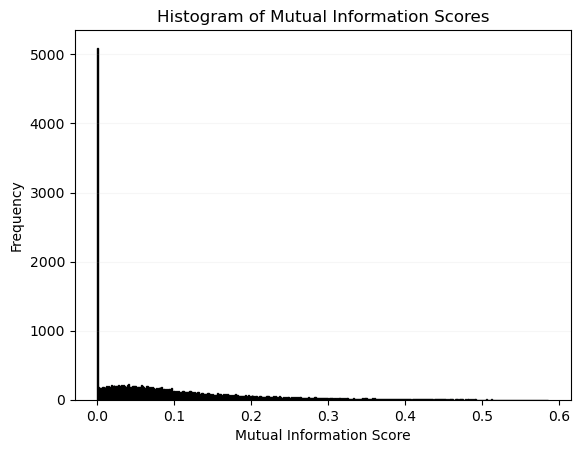

In [20]:
# histogram of mi scores

mi_all = mi_df["MI_score"]
plt.hist(mi_scores, bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of Mutual Information Scores')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.1)
plt.show()


In [21]:
top_1000_genes = top_1000_df["gene"].tolist()
x_train_mi = x_train[top_1000_genes]
x_test_mi = x_test[top_1000_genes]

In [22]:
# training random forest classifier

rf = RandomForestClassifier(random_state=1, n_estimators= 500)
rf.fit(x_train_mi, y_train)




,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [23]:
# Stratified CV - RF

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

y_pred_CV_RF = cross_val_predict(rf,  x_train, y_train, cv = cv)
cm_CV_RF = confusion_matrix(y_train, y_pred_CV_RF)
print(f"Classification matrix:\n {cm_CV_RF}")

report_CV_RF = classification_report(y_train, y_pred_CV_RF)
print(report_CV_RF)
report_CV_RF = classification_report(y_train, y_pred_CV_RF, output_dict=True)
report_CV_RF_df = pd.DataFrame(report_CV_RF).transpose()

results_RF = cross_validate(rf,  x_train, y_train, cv = cv)
test_score_RF = results_RF["test_score"]
print(f"\nAverage accuracy: "
      f"{test_score_RF.mean():.3f} ± {test_score_RF.std():.3f}")


Classification matrix:
 [[41  1]
 [ 0 87]]
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99        42
       Tumor       0.99      1.00      0.99        87

    accuracy                           0.99       129
   macro avg       0.99      0.99      0.99       129
weighted avg       0.99      0.99      0.99       129


Average accuracy: 0.992 ± 0.016


In [24]:
results_RF

{'fit_time': array([2.19880843, 2.15793991, 2.09742618, 2.15893245, 1.9992466 ]),
 'score_time': array([0.14244437, 0.13931322, 0.13539457, 0.13590264, 0.13486814]),
 'test_score': array([1.  , 1.  , 1.  , 1.  , 0.96])}

In [25]:
# prediction
y_pred_RF = rf.predict(x_test_mi)
cm_RF = confusion_matrix(y_test, y_pred_RF)

In [26]:
# Printing the Classification matrix & report of classifier - RF

cm_RF = confusion_matrix(y_test, y_pred_RF)
print(f"Classification matrix:\n {cm_RF}\n")

report_RF = classification_report(y_test, y_pred_RF)
print(report_RF)

report_RF = classification_report(y_test, y_pred_RF, output_dict=True)
report_RF_df = pd.DataFrame(report_RF).transpose()



Classification matrix:
 [[11  0]
 [ 0 22]]

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        11
       Tumor       1.00      1.00      1.00        22

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



In [27]:
importances = rf.feature_importances_

# Put into DataFrame for ranking
gene_importance = pd.DataFrame({
    'Gene': x_train_mi.columns,
    'Importance': importances
})

# Sort descending
gene_importance = gene_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(gene_importance.head(20))  # Top 20 important genes

            Gene  Importance
0         CLEC3B    0.034970
1            F10    0.031858
2          ABCA8    0.025246
3        FAM107A    0.024473
4          NXPH3    0.021258
5           NRG2    0.019473
6        CTTNBP2    0.019075
7          GPD1L    0.018952
8         CAB39L    0.018831
9            CFD    0.017175
10          ASPA    0.016922
11         GREM2    0.016700
12          PLP1    0.015426
13         CEP55    0.015366
14      TMEM132C    0.014940
15        GGTA1P    0.013847
16       PKHD1L1    0.012779
17  LOC105373266    0.011290
18         MYO10    0.011204
19       FAM149A    0.011083


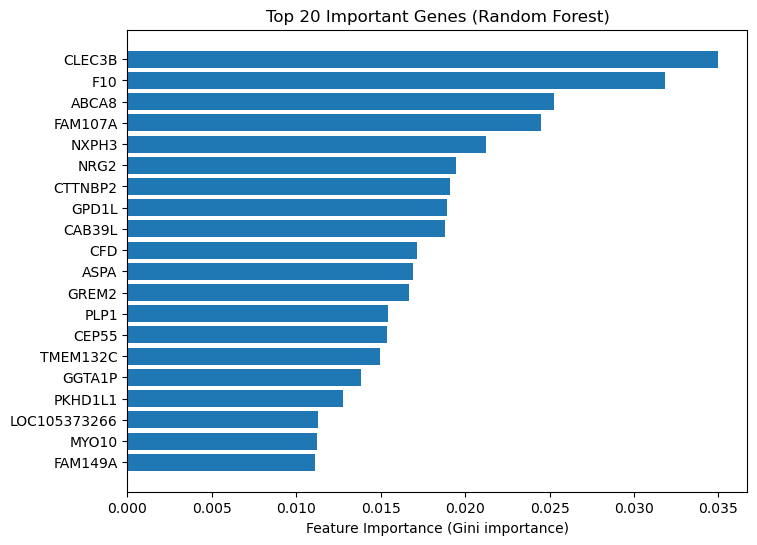

In [28]:
top_n = 20
plt.figure(figsize=(8,6))
plt.barh(gene_importance['Gene'][:top_n][::-1], 
         gene_importance['Importance'][:top_n][::-1])
plt.xlabel("Feature Importance (Gini importance)")
plt.title(f"Top {top_n} Important Genes (Random Forest)")
plt.show()

In [29]:
features_svmrfe_df = svm_rfe(x_train_mi, y_train, x_train_mi.columns)

In [1]:
features_svmrfe_df

NameError: name 'features_svmrfe_df' is not defined

In [30]:
features_svmrfe = features_svmrfe_df [features_svmrfe_df['Selected'] == True]['Features'].tolist()

In [31]:
len(features_svmrfe)

17

Testing selected genes using classification task

In [ ]:
# models to be used
logr = LogisticRegression(random_state=42, max_iter=800, solver='liblinear')
rf = RandomForestClassifier(random_state=42, n_estimators=500)
mlp = MLPClassifier(random_state=42, max_iter=800)
svc = SVC(random_state=42, probability=True)


In [33]:
x_train_rfe = x_train_mi[features_svmrfe]
x_test_rfe = x_test_mi[features_svmrfe]

In [ ]:
logr.fit(x_train_rfe, y_train)


LogR

In [48]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
y_pred_CV = cross_val_predict(logr, x_train, y_train, cv=cv)               

cv_result = cross_validate(logr, x_train, y_pred_CV, cv = cv)
report_CV = classification_report(y_train, y_pred_CV, output_dict = True)
report_CV_df = pd.DataFrame(report_CV).transpose()
#scores_cv = list(report_CV_df.iloc[4,:])
#print(cv_result)
# test score for specific fol --> five scores for 5 fold cv
test_score_mean = cv_result["test_score"].mean()
test_score_std = cv_result["test_score"].std()


In [44]:
cv_result

{'fit_time': array([4.30998015, 4.20541549, 4.41749072, 4.71660376, 5.41466665]),
 'score_time': array([0.18232989, 0.20171022, 0.20174527, 0.22573638, 0.18572044]),
 'test_score': array([1.        , 1.        , 0.96153846, 0.96153846, 1.        ])}

In [84]:
y_pred_rfe = logr.predict(x_test_rfe)


# confusion matrix for prediction
# cm = confusion_matrix(y_test, y_pred)

# evaluation --> prediction
#         scores = eval(y_test, y_pred)
report_test= classification_report(y_test, y_pred_rfe)
report_df = pd.DataFrame(report_CV).transpose()
scores = list(report_df.iloc[4,:])
roc_auc_tumor = roc_auc_score(y_test, logr.predict_proba(x_test_rfe)[:,1])

In [82]:
logr.classes_[1]

'Tumor'

(1.0, 0.0)

In [ ]:
logr.predict_proba(x_test_rfe)

array([[0.08255615, 0.91744385],
       [0.05872075, 0.94127925],
       [0.03414477, 0.96585523],
       [0.10550383, 0.89449617],
       [0.10954563, 0.89045437],
       [0.89689588, 0.10310412],
       [0.1239076 , 0.8760924 ],
       [0.92023299, 0.07976701],
       [0.00955744, 0.99044256],
       [0.01256391, 0.98743609],
       [0.94057215, 0.05942785],
       [0.01218705, 0.98781295],
       [0.98438606, 0.01561394],
       [0.04669701, 0.95330299],
       [0.96693739, 0.03306261],
       [0.92839636, 0.07160364],
       [0.04430513, 0.95569487],
       [0.06846069, 0.93153931],
       [0.01157259, 0.98842741],
       [0.98068165, 0.01931835],
       [0.04820148, 0.95179852],
       [0.97754325, 0.02245675],
       [0.98081318, 0.01918682],
       [0.94427569, 0.05572431],
       [0.97908188, 0.02091812],
       [0.04320186, 0.95679814],
       [0.01492834, 0.98507166],
       [0.02332245, 0.97667755],
       [0.06673779, 0.93326221],
       [0.00540121, 0.99459879],
       [0.